In [2]:
%matplotlib inline
import pandas as pd
from SALib.sample import latin, saltelli, fast_sampler
from SALib.sample.morris import sample
from SALib.analyze import sobol, fast, morris
from functions.stylizedfacts import *
from functions.evolutionaryalgo import *
from functions.sensitivity_analysis import *
from functions.helpers import *
import simfinmodel
import init_objects
import matplotlib.pyplot as plt
from matplotlib import style
#import quandl
import json
import scipy
import math
import ast

In [3]:
style.use('seaborn-ticks')

In [4]:
empirical_moments = np.array([ -9.56201354e-03,  -9.55051841e-02,  -5.52010512e-02,
         3.35217232e-01,   1.24673150e+01,   3.46352635e-01,
         2.72135459e-01,   1.88193342e-01,   1.75876698e-01,
        -3.39594806e+00])

W = np.array([[  3.19813864e+05,  -1.23647688e+04,  -7.75253249e+02,
         -9.96776357e+02,  -3.46059595e+01,  -8.45442951e+01,
          1.30642711e+02,   8.21228832e+02,  -7.53254275e+02,
          4.01244860e-01],
       [ -1.23647688e+04,   3.09643983e+03,  -9.12387428e+02,
          7.15088809e+02,   4.00622557e+00,  -2.07088870e+02,
          2.23333826e+02,   2.47454265e+01,  -7.69804083e+01,
         -9.32556575e-01],
       [ -7.75253249e+02,  -9.12387428e+02,   2.45450034e+03,
         -5.66285993e+02,   2.50019644e+00,   7.52973406e+01,
         -6.53708966e+01,   1.49542112e+01,  -3.22682344e+01,
         -8.15971301e-02],
       [ -9.96776357e+02,   7.15088809e+02,  -5.66285993e+02,
          6.03184170e+02,  -6.93622662e+00,  -3.92832732e+01,
          5.68213213e+01,  -2.51354209e+01,  -5.92040756e-01,
         -1.47482933e-01],
       [ -3.46059595e+01,   4.00622557e+00,   2.50019644e+00,
         -6.93622662e+00,   2.12483995e-01,  -1.07699983e+00,
          7.97173695e-01,   6.64963370e-01,  -4.66126569e-01,
          1.13807341e-03],
       [ -8.45442951e+01,  -2.07088870e+02,   7.52973406e+01,
         -3.92832732e+01,  -1.07699983e+00,   1.23523697e+04,
         -1.37167420e+04,  -1.80945248e+03,   5.03115269e+03,
         -5.47676063e-01],
       [  1.30642711e+02,   2.23333826e+02,  -6.53708966e+01,
          5.68213213e+01,   7.97173695e-01,  -1.37167420e+04,
          1.68349608e+04,  -6.34482252e+01,  -5.39173033e+03,
          4.87711333e-01],
       [  8.21228832e+02,   2.47454265e+01,   1.49542112e+01,
         -2.51354209e+01,   6.64963370e-01,  -1.80945248e+03,
         -6.34482252e+01,   5.75725915e+03,  -4.01464585e+03,
         -3.56169092e-01],
       [ -7.53254275e+02,  -7.69804083e+01,  -3.22682344e+01,
         -5.92040756e-01,  -4.66126569e-01,   5.03115269e+03,
         -5.39173033e+03,  -4.01464585e+03,   5.75734730e+03,
          5.83832248e-01],
       [  4.01244860e-01,  -9.32556575e-01,  -8.15971301e-02,
         -1.47482933e-01,   1.13807341e-03,  -5.47676063e-01,
          4.87711333e-01,  -3.56169092e-01,   5.83832248e-01,
          3.93494501e-01]])

In [5]:
confidence_intervals_moments = [[-0.014802207859241683, -0.00381338520933001],
 [-0.17714150893809588, -0.01629520926335798],
 [-0.10710049157252854, -0.009325021616514169],
 [0.1137168668465085, 0.5523703361520312],
 [2.9701436761197613, 21.711207883598597],
 [0.17229439736020258, 0.519916247879216],
 [0.08496455990583895, 0.44702201878227654],
 [0.053555935975001995, 0.3208388369069016],
 [0.05664312062039355, 0.29721186902444285],
 [-7.092498758498019, 0.3006026469341081]]#json.loads(open('bootstrapped_confidence_intervals.json').read())

## Switching contrarian style experiment
Traders switch from a fundamentalist to a mean reversion trading style.

In [6]:
NRUNS = 5

In [7]:
total_chartist_weight = 136.7

In [8]:
problem_efast = {
  'num_vars': 5,
  'names': ['trader_sample_size', 'std_noise', 'share_mr',
           'horizon_max', 'max_order_expiration_ticks'],
  'bounds': [[1, 30], [0.05, 0.30], [0.0, 1.0], [9, 30], [5, 100]]
}

In [9]:
# fix random seed?
fast_params = fast_sampler.sample(problem_efast, 400)
fast_params_list = fast_params.tolist()
# convert nescessary parameters to ints
for idx, parameters in enumerate(fast_params_list):
    # ints: 0, 3, 4
    fast_params_list[idx][0] = int(fast_params_list[idx][0])
    fast_params_list[idx][3] = int(fast_params_list[idx][3])
    fast_params_list[idx][4] = int(fast_params_list[idx][4])

In [10]:
all_parameters = []
for parameters in fast_params_list:
    pars = {}
    for key, value in zip(problem_efast['names'], parameters):
        pars[key] = value
    all_parameters.append(pars)

In [11]:
# export list of parameters
with open('SA_parameters2.json', 'w') as outfile:
    json.dump(all_parameters, outfile)

In [12]:
fixed_parameters = {"spread_max": 0.004087, "fundamental_value": 166, 
          "n_traders": 1000, 
          "ticks": 1000, "std_fundamental": 0.0530163128919286, 
          'weight_chartists': total_chartist_weight, "w_fundamentalists": 43.055017297045524, 
          "std_vol": 7, "w_random": 73.28414619497076}

In [13]:
test_labels = ['Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis',
              'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']

In [14]:
# extract J-value & MCR
model_output = sim_robustness(NRUNS, all_parameters, fixed_parameters, empirical_moments, W, confidence_intervals_moments, experiment=2)

In [17]:
# transform output, first put in df
sc_fast = pd.DataFrame(model_output)
sc_fast.to_csv('SA2_output.csv', sep='&')

In [18]:
# split df and add individual columns
sc_fast2 = pd.DataFrame(sc_fast)
#sc_fast2['mcr_scores'] = sc_fast2.mcr_scores.apply(ast.literal_eval)
sc_fast2[test_labels] = pd.DataFrame(sc_fast2.mcr_scores.values.tolist(), index= sc_fast2.index)

In [19]:
sc_fast2 = sc_fast2.loc[:, sc_fast2.columns != 'mcr_scores']
sc_fast2['share_mr'] = pd.Series([x['share_mr'] for x in all_parameters])

In [20]:
sc_fast2.head()

,j_score,Autocorrelation,Autocor1,Autocor5,Abs_autocor,Kurtosis,abs_cor10,abs_cor25,abs_cor50,abs_cor100,Cointegration,share_mr
0,269.274098,0.0,80.0,80.0,0.0,80.0,0.0,0.0,0.0,0.0,40.0,0.356234
1,176.530316,0.0,100.0,60.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.366234
2,153.569182,0.0,100.0,80.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.376234
3,204.929307,0.0,60.0,60.0,0.0,80.0,0.0,0.0,0.0,0.0,40.0,0.386234
4,130.832648,0.0,100.0,40.0,0.0,80.0,0.0,0.0,0.0,20.0,40.0,0.396234


## Scatterplots 
Scatterplots to find out if the relationship between the $w^{mfr}$ and moments is linear, non-linear of non-monotomic$

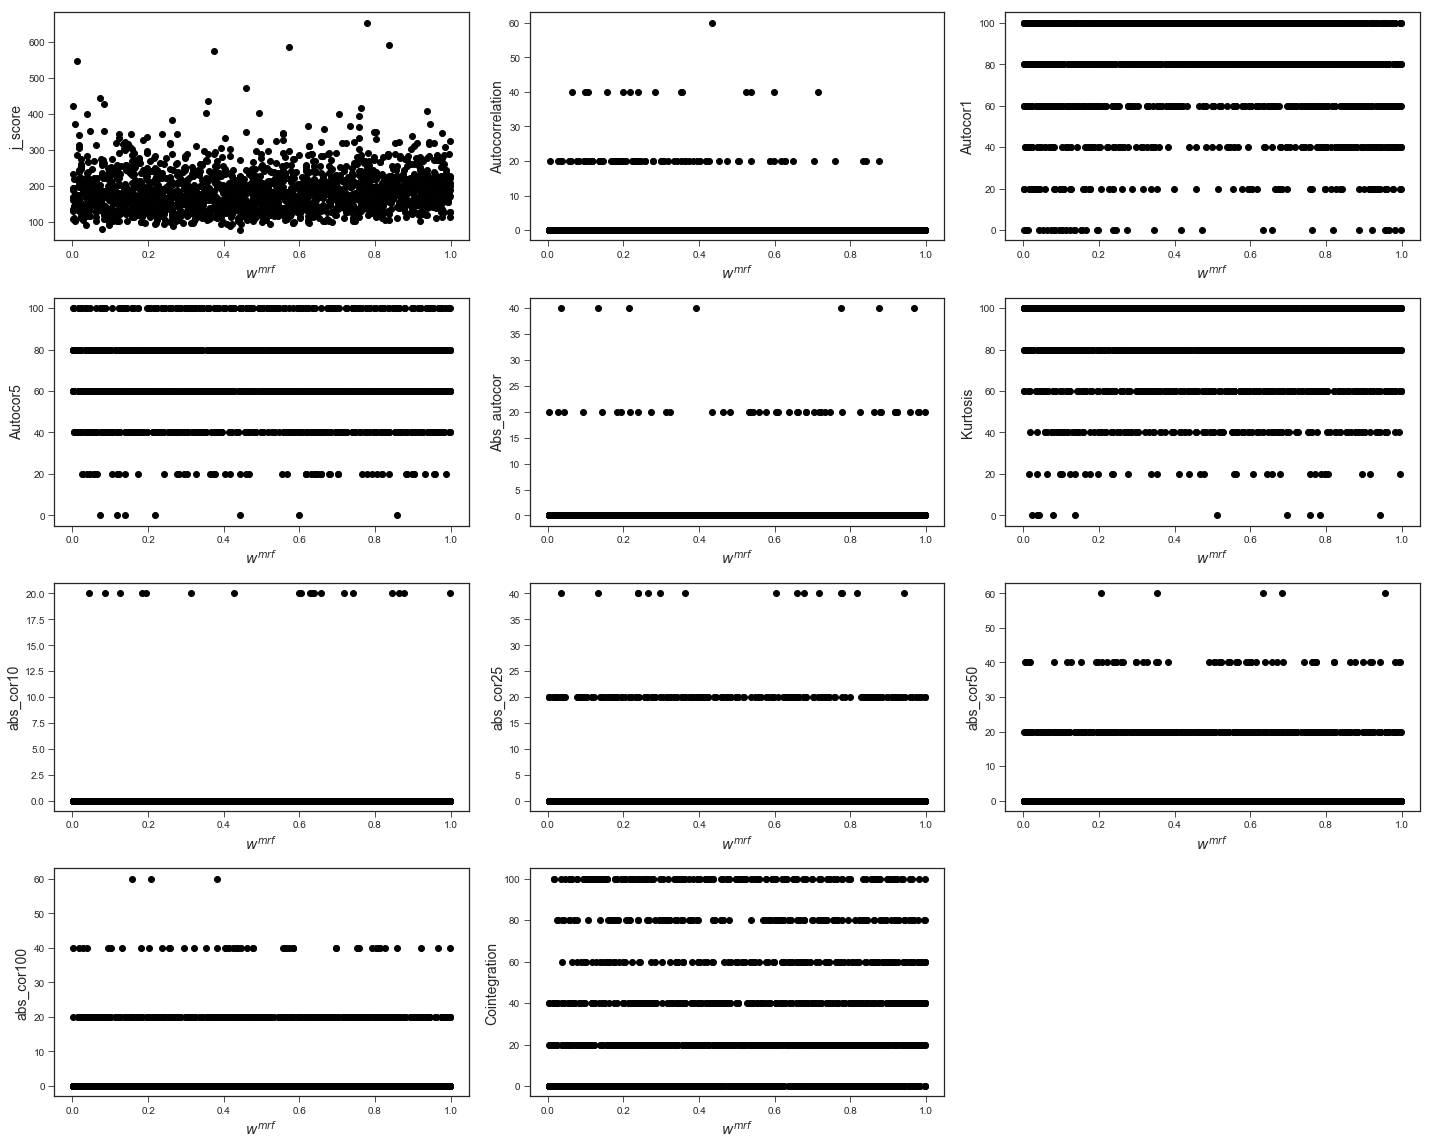

In [23]:
# do this for all moments and J-score
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 16))

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

ax1 = axes[0,0] 
ax2 = axes[0,1]
ax3 = axes[0,2]
ax4 = axes[1,0]
ax5 = axes[1,1]
ax6 = axes[1,2]
ax7 = axes[2,0]
ax8 = axes[2,1]
ax9 = axes[2,2]
ax10 = axes[3,0]
ax11 = axes[3,1]

flat_axes = [item for sublist in axes for item in sublist]
output_labels = [label for label in sc_fast2.columns if label != 'share_mr']

for ax, label in zip(flat_axes, output_labels):
    ax.plot(sc_fast2['share_mr'], sc_fast2[label], 'o', color='black')
    #ax.set_title(label)
    ax.set_ylabel(label, fontsize='14')
    
axes[3, 2].remove()

# for ax in [ax1, ax4, ax7, ax10]:
#     ax.set_ylabel('Moment', fontsize='14')
    
for ax in flat_axes:
    ax.set_xlabel('$w^{mrf}$', fontsize='14')
    

plt.tight_layout()

fig.savefig('senstivity2_scatter.png', dpi=200)

The scatterplot relationship reveals that 

1. there is a **linear monotonic** relationship for:
    - The j-score
2. there is a **non-linear monotonic** relationship for: 
    - cointegration
    - autocorrelation
3. there is a **non-monotonic**, or no relationship for 
    - autocor1
    - autocor5
    - kurtosis
    - abscor50
    - abscor100



## 1 Partial correlation coefficients  (PCC)
To find out how powerfull the effect is for the monotomic relationships 

Given that the j-score seems to show a rougly linear and monotonic relationship. The partial correlation analysis is proper. This reveals that there is a negative relationship. That is the j-score cost decreases as there are more mean-reversion traders vis à vis fundamentalist traders.  

In [22]:
def pearson(x, y):
    """Calculate pearson correlation with p-value and 5% confidence intervals"""
    corr, p_value = scipy.stats.pearsonr(x,y)
    corr_z = np.arctanh(corr)
    num = len(x)
    stderr = 1.0 / np.sqrt(num - 3)
    z = scipy.stats.norm.ppf(1 - 0.05 / 2)
    lower_z, upper_z = corr_z - z *stderr, corr_z + z *stderr
    lower, upper = np.tanh((lower_z, upper_z))
    return corr, p_value, lower, upper

In [23]:
pearson(sc_fast2['share_mr'], sc_fast2['j_score'])

(0.10967598712706988,
 8.8046294412566064e-07,
 0.066163113859758399,
 0.15277251162778374)

## 2 Partial Rank correlation coefficients (PCRC)
Since there seems to be a non-linear monototonic impact on the cointegration and autocorrelation variables. That is where I where perform the partial rank correlation coefficients test. 

In [24]:
#sc_fast2.corr(method='spearman')['share_mr'][['Autocorrelation', 'Cointegration']]

In [25]:
def spearman(x, y):
    """Calculate spearman correlation with p-value and 5% confidence intervals"""
    corr, p_val = scipy.stats.spearmanr(x, y)
    num = len(x)
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(corr) - delta)
    upper = math.tanh(math.atanh(corr) + delta)
    return corr, p_val, lower, upper

In [26]:
spearman(sc_fast2['share_mr'], sc_fast2['Cointegration'])

(0.10449830355480388,
 2.8241541270103026e-06,
 0.060945718772087834,
 0.1476537359507155)

## Get spearman for autocor

In [33]:
spearman(sc_fast2['share_mr'], sc_fast2['Autocorrelation'])

(-0.13303822725430436,
 2.3364988570788876e-09,
 -0.17584456248438185,
 -0.08972973090031795)

### Visualization

In [27]:
labels = ['J-score PCC', 'Autocorrelation PRCC', 'Cointegration PRCC']
impact = [pearson(sc_fast2['share_mr'], sc_fast2['j_score'])[0],
          spearman(sc_fast2['share_mr'], sc_fast2['Autocorrelation'])[0],
          spearman(sc_fast2['share_mr'], sc_fast2['Cointegration'])[0]]
errors = [pearson(sc_fast2['share_mr'], sc_fast2['j_score'])[3] - pearson(sc_fast2['share_mr'], sc_fast2['j_score'])[2],
        spearman(sc_fast2['share_mr'], sc_fast2['Autocorrelation'])[3] - spearman(sc_fast2['share_mr'], sc_fast2['Autocorrelation'])[2],
        spearman(sc_fast2['share_mr'], sc_fast2['Cointegration'])[3] - spearman(sc_fast2['share_mr'], sc_fast2['Cointegration'])[2]]

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,6))


ax1.errorbar(range(len(labels)), impact, fmt='o', yerr=errors, elinewidth='2')
ax1.set_ylabel('impact')
ax1.set_xlim(-0.5, 2.5)
ax1.set_xticks(np.arange(len(labels)))
ax1.set_xticklabels(labels, rotation = 45, ha="right")

fig.tight_layout()
fig.savefig('PCC-PRCC2.png', dpi=150)

TypeError: Cannot cast array data from dtype('S1') to dtype('float64') according to the rule 'safe'

Error in callback <function post_execute at 0x0000000007D882E8> (for post_execute):


TypeError: Cannot cast array data from dtype('S1') to dtype('float64') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('S1') to dtype('float64') according to the rule 'safe'

<Figure size 432x432 with 1 Axes>

## eFast analysis 
Then, I apply the eFast analysis tool to all other parameters. 

In [29]:
# Create lists of variables to be used in each eFast analysis
eFast_labels = ['j_score', 'Autocorrelation', 'Autocor1', 'Autocor5', 'Abs_autocor', 'Kurtosis', 'abs_cor10', 'abs_cor25', 'abs_cor50', 'abs_cor100', 'Cointegration']
e_fast = {}

for efl in eFast_labels:
    e_fast[efl] = fast.analyze(problem_efast, sc_fast2[efl], print_to_console=False)

In [30]:
direct_effects = [(label, e_fast[label]['S1'][2]) for label in eFast_labels]
indirect_effects = [(label, e_fast[label]['ST'][2]) for label in eFast_labels]

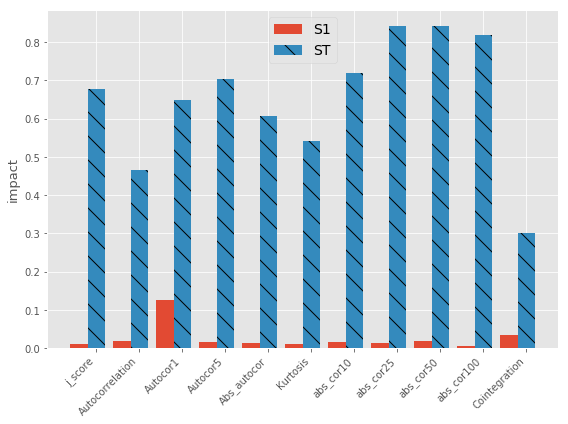

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))

N = len(direct_effects)
ind = np.arange(N)  # the x locations for the groups
width = 0.4#0.40       # the width of the bars

#ax1.set_title('Cointegration')
rects1 = ax1.bar(ind, [x[1] for x in direct_effects], width)
rects2 = ax1.bar(ind + width, [x[1] for x in indirect_effects], width, hatch='\\', color=list(plt.rcParams['axes.prop_cycle'])[1]['color'])
ax1.legend((rects1[0], rects2[0]), ('S1', 'ST'), loc='upper center', fontsize ='14')
ax1.set_ylabel('impact', fontsize='13')

ax1.set_xticks(ind + width) #/ 2)
ax1.set_xticklabels(eFast_labels, rotation = 45, ha="right")
#ax1.set_ylim(0, 0.7)

#ax1.legend(loc='best')
plt.axis('tight')
fig.tight_layout()

fig.savefig('eFast2.png', dpi=200)